# Fruit and Vegetables Image Classification

## 資料來源
包含多種水果圖像的資料集，適合用於圖像分類和計算機視覺任務  

[Fruits and Vegetables Image Recognition Dataset](https://www.kaggle.com/datasets/kritikseth/fruit-and-vegetable-image-recognition/data)

### 1.掛載 Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 2.匯入必要模組和函式庫

In [13]:
import numpy as np
import pandas as pd
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import sys

from pathlib import Path
from collections import Counter
from PIL import Image
from tensorflow.keras import layers, models
from tensorflow.keras import optimizers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

print('python版本:',sys.version)
print('tensorflow版本:',tf.__version__)

python版本: 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]
tensorflow版本: 2.18.0


### 3.獲取影像檔案路徑
- 定義 get_image_filepaths() 函式，獲取指定目錄內所有 .jpg 影像檔案路徑

In [14]:
# 定義函式來獲取指定目錄中的所有圖片檔案路徑
def get_image_filepaths(directory):
    return list(Path(directory).glob(r'**/*.jpg'))

# 獲取所有圖像路徑
train_filepaths = get_image_filepaths('/content/drive/MyDrive/3.Python深度學習應用開發/Fruit-and-Vegetables-Image-Classification-main/train')
test_filepaths = get_image_filepaths('/content/drive/MyDrive/3.Python深度學習應用開發/Fruit-and-Vegetables-Image-Classification-main/test')
val_filepaths = get_image_filepaths('/content/drive/MyDrive/3.Python深度學習應用開發/Fruit-and-Vegetables-Image-Classification-main/validation')

### 4.建立影像路徑與標籤的 DataFrame
- 定義 proc_img() 函式，從影像路徑提取標籤，並建立 DataFrame。

In [15]:
# 處理圖像路徑以創建 DataFrame
def proc_img(filepaths):
    data = []
    for filepath in filepaths:
        label = filepath.parent.name # 標籤是資料夾名稱
        data.append({'Filepath':str(filepath),'Label':label})
    return pd.DataFrame(data)

# 從圖像路徑產生訓練、測試和驗證資料集的DataFrame
train_df = proc_img(train_filepaths)
test_df = proc_img(test_filepaths)
val_df = proc_img(val_filepaths)

# 打亂測試集，確保模型評估時公平
test_df = test_df.sample(frac=1).reset_index(drop=True)

# 確保DataFrame正確
print("Training set samples:")
print(train_df.head(3))
print("\nTesting set samples:")
print(test_df.head(3))
print("\nValidation set samples:")
print(val_df.head(3))

Training set samples:
                                            Filepath  Label
0  /content/drive/MyDrive/3.Python深度學習應用開發/Fruit-...  apple
1  /content/drive/MyDrive/3.Python深度學習應用開發/Fruit-...  apple
2  /content/drive/MyDrive/3.Python深度學習應用開發/Fruit-...  apple

Testing set samples:
                                            Filepath   Label
0  /content/drive/MyDrive/3.Python深度學習應用開發/Fruit-...    corn
1  /content/drive/MyDrive/3.Python深度學習應用開發/Fruit-...    kiwi
2  /content/drive/MyDrive/3.Python深度學習應用開發/Fruit-...  turnip

Validation set samples:
                                            Filepath  Label
0  /content/drive/MyDrive/3.Python深度學習應用開發/Fruit-...  apple
1  /content/drive/MyDrive/3.Python深度學習應用開發/Fruit-...  apple
2  /content/drive/MyDrive/3.Python深度學習應用開發/Fruit-...  apple


### 5.分析與視覺化各類別的樣本數量分布
- 使用 Counter 計算 train_df、test_df 和 val_df 中各類別的樣本數量
- 建立 DataFrame 統整訓練、測試與驗證集的類別樣本分布，並計算總數

Number of categories: 36

Category distribution by sample count:
               Train  Test  Validation  Total
soy beans         92    10          10    112
peas              90     9           9    108
spinach           87    10          10    107
lettuce           87     9           9    105
turnip            85    10          10    105
beetroot          84    10          10    104
cabbage           84    10          10    104
tomato            84    10          10    104
corn              84    10          10    104
pineapple         84    10          10    104
sweetcorn         83    10          10    103
garlic            83    10          10    103
kiwi              82    10          10    102
grapes            85     8           8    101
watermelon        79    10          10     99
cucumber          78    10          10     98
onion             80     9           9     98
capsicum          80     9           9     98
eggplant          77    10          10     97
jalepeno       

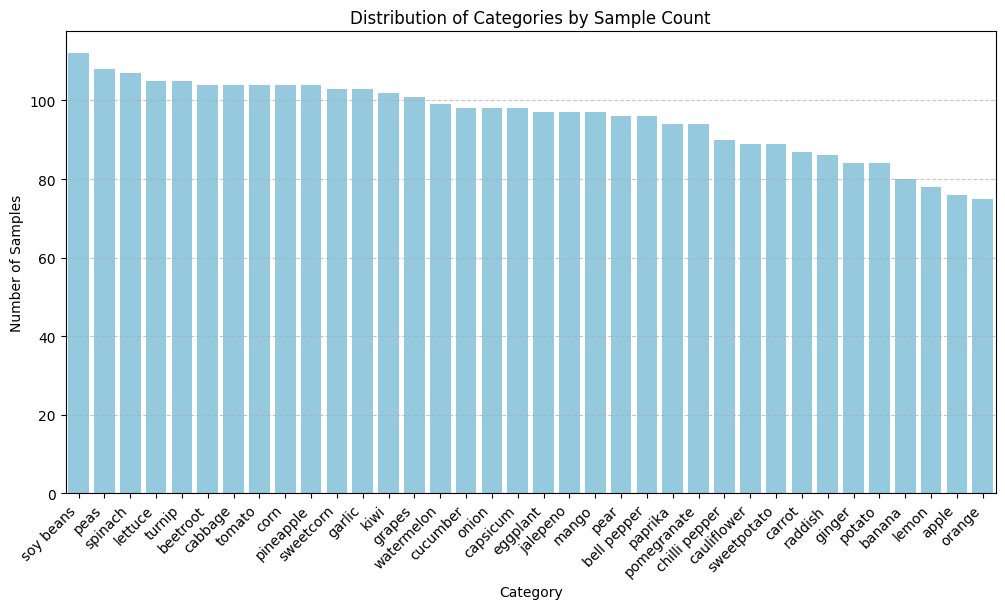

In [16]:
# 分析每個類別的樣本數量
train_label_counts = Counter(train_df['Label'])
test_label_counts = Counter(test_df['Label'])
val_label_counts = Counter(val_df['Label'])

# 創建一個包含每個類別在各數據集中的樣本數量的 DataFrame
label_distribution = pd.DataFrame({
    'Train':pd.Series(train_label_counts),
    'Test':pd.Series(test_label_counts),
    'Validation':pd.Series(val_label_counts)
}).fillna(0).astype(int)

# 計算總樣本數
label_distribution['Total'] = label_distribution.sum(axis=1)
label_distribution = label_distribution.sort_values('Total',ascending=False)

# 顯示類別分布的統計資訊
print("Number of categories:",len(label_distribution))
print("\nCategory distribution by sample count:")
print(label_distribution)

print("\nTotal samples per dataset:")
print(f"Training:{len(train_df)},Testing:{len(test_df)},Validation:{len(val_df)}")
print(f"Total samples:{len(train_df)+len(test_df)+len(val_df)}")

# 視覺化類別分布的條形圖
plt.figure(figsize=(12,6))
sns.barplot(data=label_distribution.reset_index(),x="index",y="Total",color="skyblue")
plt.title('Distribution of Categories by Sample Count')
plt.xlabel('Category')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45,ha='right')
plt.grid(axis='y',linestyle='--',alpha=0.7)
plt.show()

### 6.顯示每個類別的第一張圖像
- 創建一個字典來存儲每個類別的第一張影像，並使用 Matplotlib 顯示這些影像

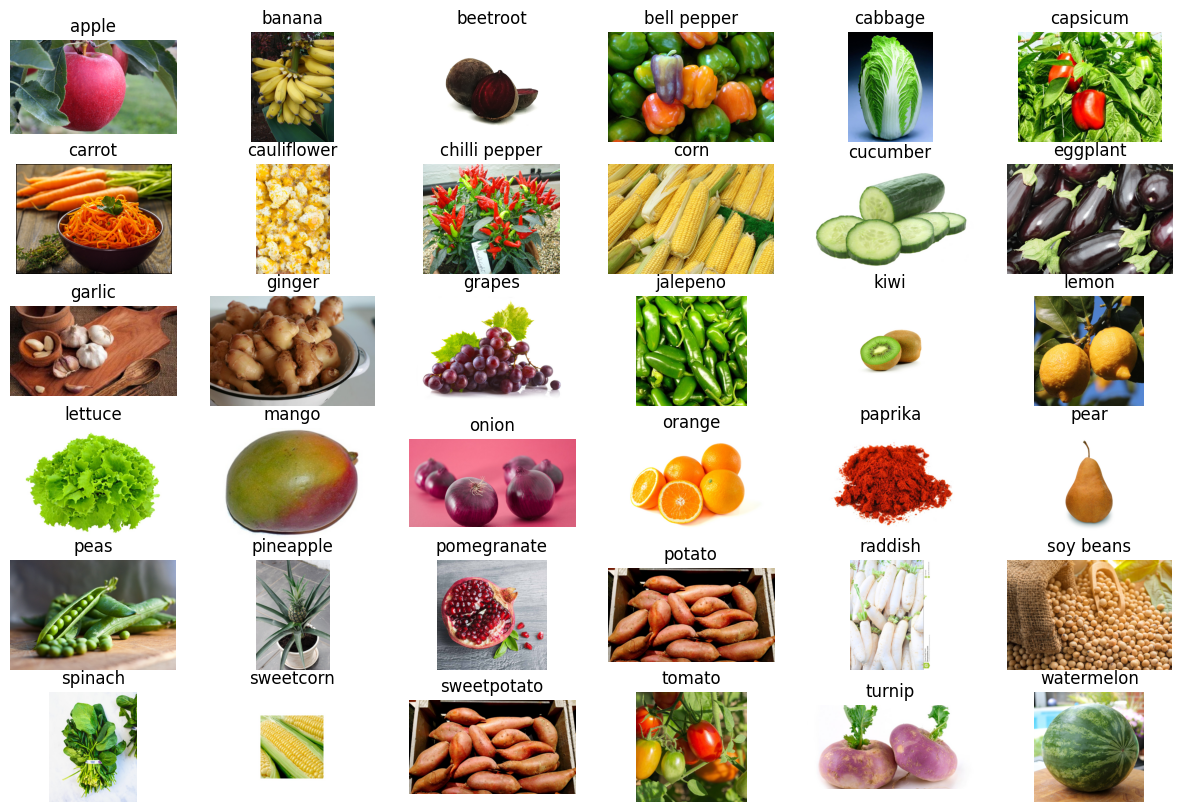

In [17]:
first_images = {}
for category in train_df['Label'].unique():
    first_images[category] = train_df[train_df['Label'] == category]['Filepath'].values[0]

plt.figure(figsize=(15,10))
for i, (category, image_path) in enumerate(first_images.items()):
    image = Image.open(image_path)
    plt.subplot(6,6,i+1) # i+1 是因為 subplot 從 1 開始
    plt.imshow(image)
    plt.title(category)
    plt.axis('off')

plt.show()

### 7.創建影像數據生成器進行數據增強和預處理

In [ ]:
# 使用 ImageDataGenerator 進行數據增強
train_datagen = ImageDataGenerator(
    rescale=1./255, # 將像素值縮放到 [0, 1] 之間
    rotation_range=40, # 隨機旋轉圖片
    width_shift_range=0.2, # 隨機水平平移
    height_shift_range=0.2, # 隨機垂直平移
    shear_range=0.2, # 隨機剪切(沿某個方向傾斜)
    zoom_range=0.2, # 隨機縮放
    horizontal_flip=True, # 隨機水平翻轉
    brightness_range=[0.8, 1.2], # 隨機調整亮度
    channel_shift_range=0.2, # 隨機改變顏色通道
    fill_mode='nearest' # 填充新創建像素的方法
)

# 創建 ImageDataGenerator 用於驗證和測試數據集（不進行增強）
test_datagen = ImageDataGenerator(rescale=1./255)

# 創建數據生成器
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical' # 使用 categorical_crossentropy 損失函數
)

val_generator = test_datagen.flow_from_dataframe(
    val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical'
)

# 在創建數據生成器之前打亂數據框
test_df = test_df.sample(frac=1).reset_index(drop=True)

# 重新創建數據生成器
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 2780 validated image filenames belonging to 36 classes.
Found 334 validated image filenames belonging to 36 classes.
Found 334 validated image filenames belonging to 36 classes.


### 8.載入並配置預訓練模型 MobileNetV2

In [ ]:
# 載入預訓練模型
base_model = MobileNetV2(
    input_shape=(224,224,3), # 輸入圖像的形狀
    include_top=False, # 不包含頂層的全連接層
    weights='imagenet', # 使用 ImageNet 預訓練權重
    pooling='avg' # 全局平均池化
)
base_model.trainable = False

# 顯示模型摘要
# base_model.summary()

### 9.建立並訓練影像分類模型

In [ ]:
# 建立模型
input = base_model.input
x = layers.Dense(512,activation='relu')(base_model.output)
x = layers.Dense(256,activation='relu')(x)
x = layers.Dense(128,activation='relu')(x)
x = layers.Dense(64,activation='relu')(x)
output = layers.Dense(36,activation='softmax')(x)

model = models.Model(inputs=input,outputs=output)

# 編譯模型
model.compile(optimizer=optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 設置回調函數
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='/content/drive/MyDrive/3.Python深度學習應用開發/03_水果/fruit_model.keras',
        save_best_only=True, # 只儲存性能最好的模型（根據監控指標）
        monitor='val_accuracy', # 監控驗證集的準確率
        mode='max' # 當 val_accuracy 最大時，儲存模型
    )
]

# 訓練模型
history = model.fit(train_generator, # 使用訓練集數據
                    validation_data=val_generator, # 使用驗證集數據
                    epochs=50,
                    callbacks=callbacks)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


87/87 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.2390 - loss: 2.8723 - val_accuracy: 0.7605 - val_loss: 0.9004
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.6554 - loss: 1.1117 - val_accuracy: 0.8054 - val_loss: 0.6037
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - accuracy: 0.7465 - loss: 0.7687 - val_accuracy: 0.8533 - val_loss: 0.4380
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.7940 - loss: 0.6681 - val_accuracy: 0.8802 - val_loss: 0.3925
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.7965 - loss: 0.6167 - val_accuracy: 0.8802 - val_loss: 0.3505
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.8471 - loss: 0.4418 - val_accuracy: 0.8832 - val_loss: 0.3153
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.8533 - loss: 0.4350 - val_accuracy: 0.8922 - val_loss: 0.3279
Epoch 8/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.8456 - loss: 0.4437 - val_accuracy: 0.8653 - val_loss: 0.

### 10.視覺化模型訓練過程中的準確率和損失
- 將模型訓練過程中的準確率和損失數據轉換為 DataFrame
- 使用 Matplotlib 繪製出訓練和驗證過程中的準確率和損失曲線

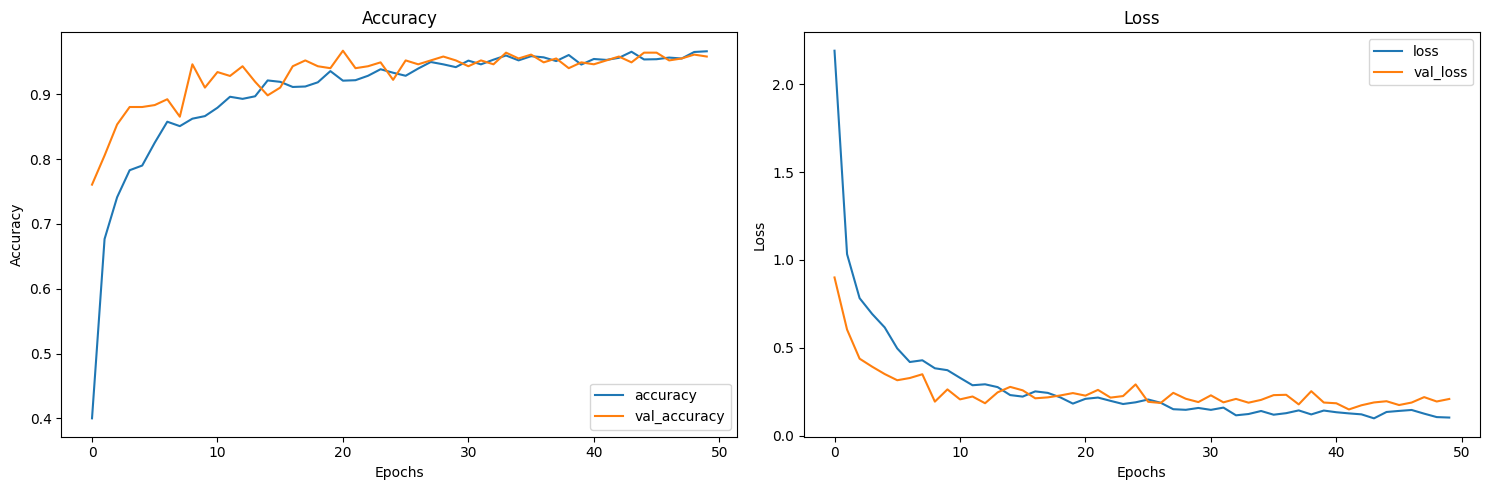

In [ ]:
# 將訓練歷史轉換為 DataFrame
result = pd.DataFrame(history.history)

# 創建子圖
fig, axes = plt.subplots(1,2,figsize=(15, 5))

# 繪製準確率曲線
result[['accuracy','val_accuracy']].plot(ax=axes[0])
axes[0].set_title("Accuracy")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Accuracy")

# 繪製損失曲線
result[['loss','val_loss']].plot(ax=axes[1])
axes[1].set_title("Loss")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss")

# 調整佈局並顯示圖表
plt.tight_layout()
plt.show()

### 11.獲取並顯示標籤對應表

In [ ]:
# 獲取標籤對應表
label_map = train_generator.class_indices

# 反轉字典以便於查詢
label_map = {v:k for k, v in label_map.items()}

# 顯示標籤對應表
print(label_map)

{0: 'apple', 1: 'banana', 2: 'beetroot', 3: 'bell pepper', 4: 'cabbage', 5: 'capsicum', 6: 'carrot', 7: 'cauliflower', 8: 'chilli pepper', 9: 'corn', 10: 'cucumber', 11: 'eggplant', 12: 'garlic', 13: 'ginger', 14: 'grapes', 15: 'jalepeno', 16: 'kiwi', 17: 'lemon', 18: 'lettuce', 19: 'mango', 20: 'onion', 21: 'orange', 22: 'paprika', 23: 'pear', 24: 'peas', 25: 'pineapple', 26: 'pomegranate', 27: 'potato', 28: 'raddish', 29: 'soy beans', 30: 'spinach', 31: 'sweetcorn', 32: 'sweetpotato', 33: 'tomato', 34: 'turnip', 35: 'watermelon'}


### 12.載入最佳模型並使用測試數據進行預測

In [ ]:
# 載入最佳模型
model = tf.keras.models.load_model('/content/drive/MyDrive/3.Python深度學習應用開發/03_水果/fruit_model.keras')

# 使用測試數據生成器進行預測
test_loss,test_accuracy = model.evaluate(test_generator)
print(f'Test accuracy:{test_accuracy * 100:.2f}%')

# 獲取預測結果
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions,axis=1)

# 顯示前10個預測結果和實際結果
predicted_labels = [label_map[i] for i in predicted_classes[:10]]
actual_labels = [label_map[i] for i in test_generator.classes[:10]]

print("Predicted labels:",predicted_labels)
print("Actual labels:",actual_labels)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.9727 - loss: 0.2778
Test accuracy: 96.71%
11/11 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step
Predicted labels: ['cabbage', 'turnip', 'cabbage', 'pineapple', 'turnip', 'garlic', 'bell pepper', 'raddish', 'orange', 'beetroot']
Actual labels:    ['cabbage', 'turnip', 'cabbage', 'pineapple', 'turnip', 'garlic', 'bell pepper', 'raddish', 'orange', 'beetroot']


### 13.顯示混淆矩陣
- 評估模型在測試數據上的預測效果

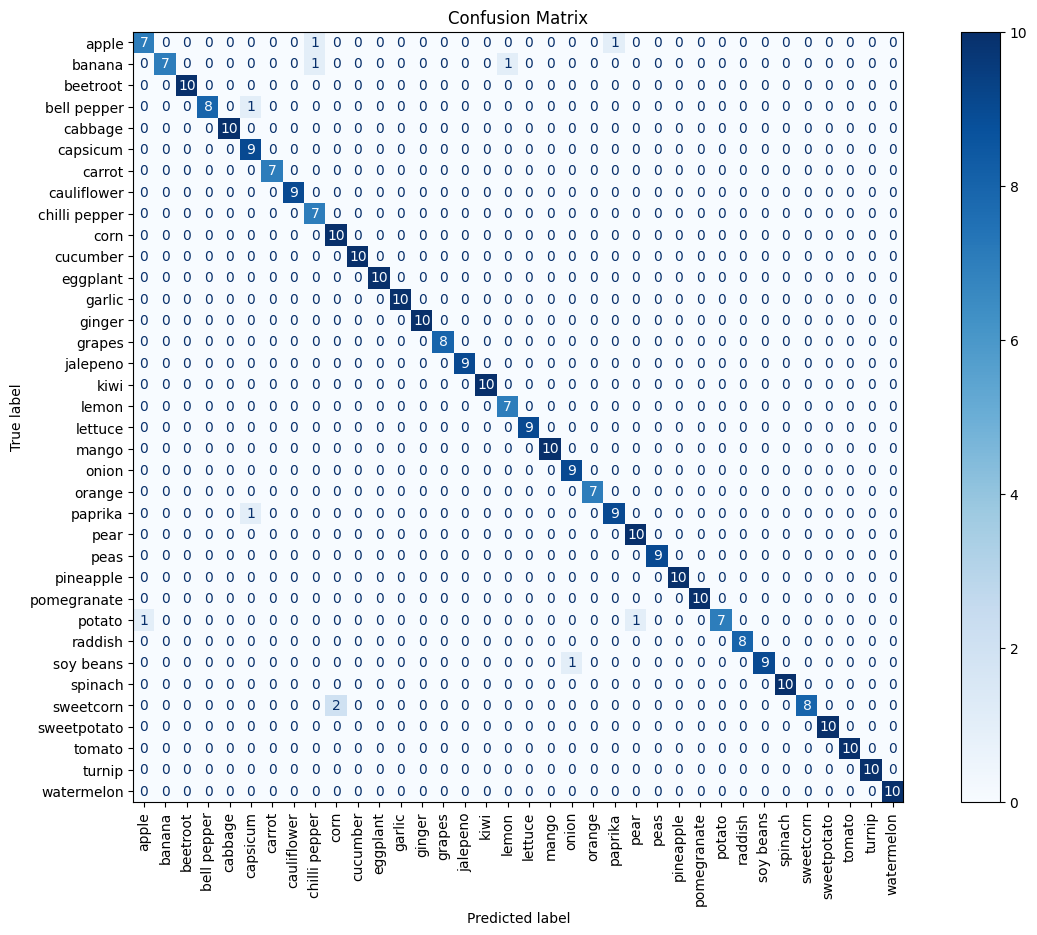

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

true_classes = test_generator.classes
pred_classes = predicted_classes

# 產生混淆矩陣
cm = confusion_matrix(true_classes,pred_classes)

# 顯示混淆矩陣
fig,ax = plt.subplots(figsize=(15,10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=test_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues,ax=ax)

# 自定義圖形
plt.xticks(rotation=90)  # 旋轉 x 軸標籤以提高可讀性
plt.title('Confusion Matrix')
plt.show()